In [27]:
"""intent: to make the simplest model and submit to kaggle to have a baseline to start
todo: transfer learning from resnet, 
- scramble final layer
- redo classifer"""


'intent: to make the simplest model and submit to kaggle to have a baseline to start\ntodo: transfer learning from resnet, \n- scramble final layer\n- redo classifer'

setup tasts
rename data/train/train (where the images are)
to data/train/images

In [28]:
from fastai.vision.all import *

In [37]:
import os
import pandas as pd

train_dir = 'data/train/images'
path = Path('data/train/images')
image_files = os.listdir(train_dir)
df = pd.DataFrame({'filename': image_files})
df['id'] = df['filename'].str.split('.').str[0]
print(df.head())

                     filename      id
0  660315.jpg:Zone.Identifier  660315
1                  135654.jpg  135654
2  150810.jpg:Zone.Identifier  150810
3  804916.jpg:Zone.Identifier  804916
4                  759913.jpg  759913


Random row data:
id                  280456
shapeset                 2
type                     1
total_height             5
instability_type         2
cam_angle                1
stable_height            2
Name: 2105, dtype: int64


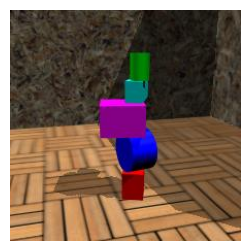

In [30]:
import pandas as pd
import random
from PIL import Image
import os
import matplotlib.pyplot as plt

# Load the data
train_data = pd.read_csv('data/train/train.csv')



# # Pick a random row
# random_row = train_data.sample(n=1).iloc[0]

# Print the data for the random row
print("Random row data:")
print(random_row)

# Display the relevant image
image_path = os.path.join('data', 'train', 'images', f"{random_row['id']}.jpg")
try:
    img = Image.open(image_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Image not found: {image_path}")

In [31]:
files = get_image_files(train_dir)
len(files)

7680

In [32]:
#ignoring extra info just label
# Assuming you've already loaded your CSV into a DataFrame called 'train_data'
id_to_label = dict(zip(train_data['id'], train_data['stable_height']))

In [42]:


from pathlib import Path

def label_func(file_path):
    if isinstance(file_path, str):
        file_path = Path(file_path)
    file_name = file_path.name
    image_id = file_name.split('.')[0]  # Assumes filenames are like "id.jpg"
    return id_to_label[int(image_id)]

# Test the function
print(label_func(files[0]))

5


In [43]:
path = Path('data/train')

In [44]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

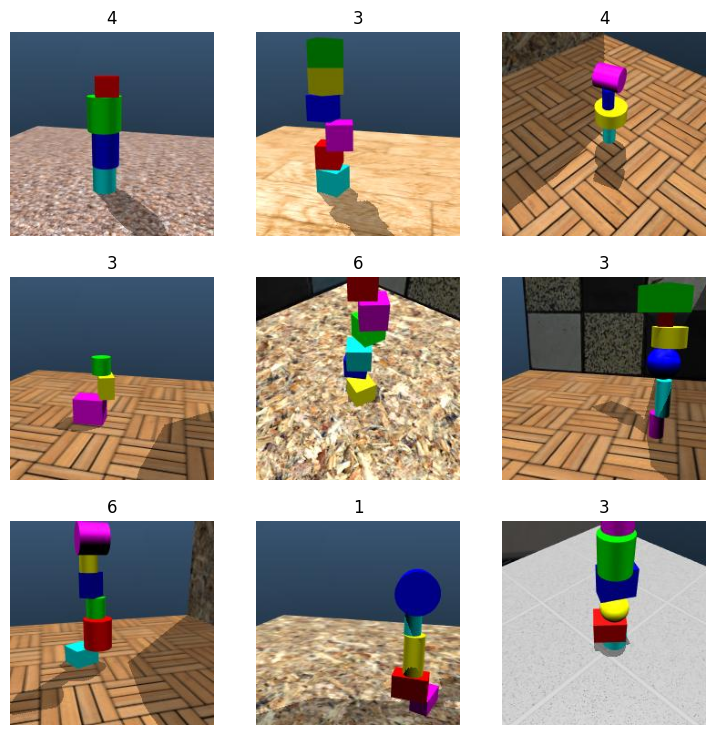

In [45]:
dls.show_batch()

In [46]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/highorder/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
 53%|█████▎    | 44.4M/83.3M [00:52<00:49, 826kB/s] 

In [ ]:
learn.predict(files[0])

In [ ]:
learn.show_results()

1. load the data
